# Python project
## Tennis calculator

Firstly we will import important libraries for our project.

In [22]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from time import sleep
from tqdm import tqdm
import re

Let's define functions that will help us with scraping our data.

In [23]:
def getSoup(link):###vytvoříme funkci, která získá z URL adresy text
    sleep(0.05)
    r = requests.get(link)
    return BeautifulSoup(r.text,'lxml')

In [24]:
def getAllLinks(link):###najdeme tabulku linků
    soup = getSoup(link)
    table = soup.find('table', {'id':'reportable'})
    tds = table.findAll('td', {'align':'left'})
    a = [td.find('a') for td in tds]
    res = [i for i in a if i]
    return res

We create the list of links to individual player statistics. 

In [25]:
links = getAllLinks('http://tennisabstract.com/reports/atpRankings.html')###získáme všechny linky

In [26]:
b = [str(links[i])for i in range(len(links))]
c = [i.replace('"', '!') for i in b]
d = [o.split("!") for o in c]
flinks = [d[p][1] for p in range(len(d))]

Now it's time to create a list of player names and choose the amount of players involved in our further calculations.

In [27]:
Namesss = [flink.replace('http://www.tennisabstract.com/cgi-bin/player.cgi?p=', '') for flink in flinks]###získáme jména
Names=Namesss[:150]

In [29]:
finallist = []###udeláme list, ve kterém jsou listy z údaji jednotlivých hráčů
ranx = 0
for nam in Names:
    ranx += 1
    soop = getSoup('http://www.minorleaguesplits.com/tennisabstract/cgi-bin/frags/'+nam+'.js')
    playerlist = []
    name_str = nam
    name_list = []
    name_list = re.findall('[A-Z][^A-Z]*', name_str)
    namstr = ' '.join(map(str, name_list))
    playerlist.append(namstr)
    playerlist.append(ranx)
    if (soop.find('table', {'id':'tour-years'})):
        statstable = soop.find('table', {'id':'tour-years'})
        statsdfs = pd.read_html(str(statstable), index_col = 0)
        statsdf = statsdfs[0]
        playerlist.append(statsdf.at['Career', 'Hld%'])
        playerlist.append(statsdf.at['Career', 'Brk%'])
    else:
        playerlist.append("No data")
        playerlist.append("No data")
    finallist.append(playerlist)

Further we proceed with creating a dataframe from the data we got in previous step.

In [32]:
finalldf = pd.DataFrame(finallist, columns = ['Name', 'Rank', 'Hld%', 'Brk%'])###uděláme dataframe
for i in range(len(Names)):###pomocný dataframe, který nám pomáhá při hledání hráče u tenisové tří dy tenisový hráč    
    finalldf.rename(columns={},index={i:finalldf.at[i,"Name"]},inplace=True)
finalldf

,Name,Rank,Hld%,Brk%
Novak Djokovic,Novak Djokovic,1,85.8%,32.0%
Rafael Nadal,Rafael Nadal,2,85.9%,33.5%
Dominic Thiem,Dominic Thiem,3,83.1%,23.8%
Daniil Medvedev,Daniil Medvedev,4,82.5%,25.6%
Roger Federer,Roger Federer,5,88.8%,26.7%
...,...,...,...,...
Francisco Cerundolo,Francisco Cerundolo,146,61.5%,26.9%
Oscar Otte,Oscar Otte,147,80.6%,20.0%
Marc Andrea Huesler,Marc Andrea Huesler,148,82.0%,19.6%
Ivo Karlovic,Ivo Karlovic,149,92.0%,8.5%


## Graphs
Following graphs show us the dependence between hold (or break) percentage in % and player's rank.

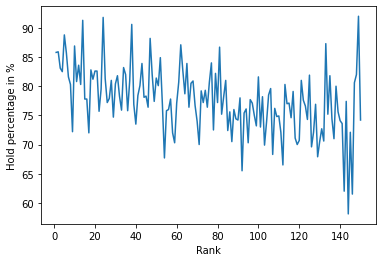

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
rank=finalldf['Rank']###uděláme graf, který ukazuje závislost mezi rankingem a pravděpodobností udržení servisu daného hráče
hold=[float(finallist[i][2].replace("%","")) for i in range(len(finallist))]
plt.plot(rank,hold)
plt.xlabel('Rank')
plt.ylabel('Hold percentage in %')
plt.show()

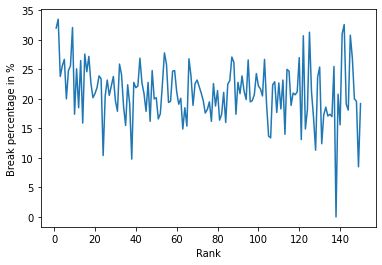

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
rank=finalldf['Rank']###uděláme graf, který ukazuje závislost mezi rankingem a pravděpodobností breaknutí servisu soupeře
breaky=[float(finallist[i][3].replace("%","")) for i in range(len(finallist))]
plt.plot(rank,breaky)
plt.xlabel('Rank')
plt.ylabel('Break percentage in %')
plt.show()

Let's define class Tennisplayer, that helps us with getting data from our dataframe.

In [18]:
class Tennisplayer:     ###definujeme si třídu tenisového hráče
    def __init__(self,name):
        self.name = name
        
    def ranking(self,name):
        return finalldf.at[name,"Rank"]
    def servis(self,name):
        return finalldf.at[name,"Hld%"]
    def returny(self,name):
        return finalldf.at[name,"Brk%"]

## Functions for our calculations
Now we will define some essential functions to help us get the results.

In [35]:
def nodata(vstup):           ###u některých hráčů nemáme data, a tak chceme ověřit že náš hráč je má
    if vstup=="No data":
        Entry.insert(E4,0,"No data")
        print("No data")
        Entry.insert(E5,0,"No data")
        print("No data")
        return None
    
def numerizace(vstup):      ###chceme to dostat do formátu čísla na výpočty, takže procento tam nechce
    return float(vstup[:-1])

def elo(vstup):             ###nadefinujeme si náš elo žebříček, aby se nemohlo stát, že hráč s vyšším rankingem
    if vstup>200:           ###nebude favoritem utkáním
        vstup+=30
    if vstup>80 and vstup<201:
        vstup+=25
    if vstup>50 and vstup<81:
        vstup+=21 
    if vstup>30 and vstup<51:
        vstup+=17 
    if vstup>16 and vstup<31:
        vstup+=13
    if vstup>8 and vstup<17:
        vstup+=10
    if vstup>2 and vstup<9:
        vstup+=7        
    if vstup>0 and vstup<3:
        vstup+=4
    return vstup 

def differ(B,C):          ###spočítáme přibližný rozdíl mezi pravděpodobnostmi na servisu podle jejich ela
    P1=C/(B+C)
    P2=B/(B+C)
    diffskill=P1-P2
    diffskill=diffskill if diffskill>0 else -diffskill
    diff=0
    mini=min(P1,P2)
    diff=0.4-(((2*mini)**0.7)*0.4)
    return diff

def parametrcalc(a,b,c,d,Surface,P1,P2,diff):   ###výpočet- vstupní hodnoty jsou jejich statistiky ze servisu, rankingu,
    avgserve=(a+b)/2                            ###returnu a povrchu na kterém hrají, ve výpočtu zavádíme parametry aby naše
    avgreturn=(c+d)/2                           ### zhruba odpovídaly realitě
    eqserve=avgserve/(avgserve+avgreturn)
    eqreturn=avgreturn/(avgserve+avgreturn)
    serpar=eqserve**0.7
    retpar=eqreturn**0.7
    PS1,PS2,PR1,PR2,K,L=0,0,0,0,0,0
    if P1>P2:
        PS1=eqserve+(diff*(retpar/(retpar+serpar)))
        PS2=eqserve-(diff*(serpar/(retpar+serpar)))
        PR1=1-PS2
        PR2=1-PS1
    else:
        PS1=eqserve-(diff*(serpar/(retpar+serpar)))
        PS2=eqserve+(diff*(retpar/(retpar+serpar)))
        PR1=1-PS2
        PR2=1-PS1        
  
    if Surface =="Clay":
        K=PS1
        L=PS2  
        PS1+=-(K)*(L/10)
        PS2+=-(K)*(L/10)
        PR1=1-PS2
        PR2=1-PS1
        result=[PS1,PS2,PR1,PR2]
        return result
    if Surface =="Hard":
        result=[PS1,PS2,PR1,PR2]
        return result
    if Surface=="Grass":
        K=PS1
        L=PS2                 
        PS1=K+((1-K)*(1/5))
        PS2=L+((1-L)*(1/5))
        PR1=1-PS2
        PR2=1-PS1
        result=[PS1,PS2,PR1,PR2]
        return result
    else:
        result=[PS1,PS2,PR1,PR2]
        return result

## Calculator of probability of serve win in 1v1 matchup between specific players
After starting the calculator, you will be asked to write exact names of two specific players (from the dataframe) and the surface on which the match will be played.
You will get the resulting probabilities that they will hold their serve in one game.

In [36]:
#tři vstupy, výstupy pravděpodobnost výhry servisů(returnu)
import tkinter
from tkinter import *
from tkinter import messagebox
def proces1():    ###používáme naše předdefinované funkce k celému procesu výpočtu
    Tennisplayer1,Tennisplayer2,Surface=Entry.get(E1),Entry.get(E2),Entry.get(E3)  ###naše vstupní hodnoty
    h1,h2=Tennisplayer(Tennisplayer1),Tennisplayer(Tennisplayer2)
    Tennisplayer1ranking,Tennisplayer2ranking=h1.ranking(Tennisplayer1),h2.ranking(Tennisplayer2)
    Tennisplayer1servis,Tennisplayer2servis=h1.servis(Tennisplayer1),h2.servis(Tennisplayer1)
    nodata(Tennisplayer1servis)
    nodata(Tennisplayer2servis)
    Tennisplayer1returny=h1.returny(Tennisplayer1) 
    Tennisplayer2returny=h2.returny(Tennisplayer2)
    nodata(Tennisplayer1returny)
    nodata(Tennisplayer2returny)
       
    Tennisplayer1servis=numerizace(Tennisplayer1servis)
    Tennisplayer2servis=numerizace(Tennisplayer2servis)
    Tennisplayer1returny=numerizace(Tennisplayer1returny)
    Tennisplayer2returny=numerizace(Tennisplayer2returny)
        
    B=elo(Tennisplayer1ranking)
    C=elo(Tennisplayer2ranking)
    P1=C/(B+C)
    P2=B/(B+C)
    diff=differ(B,C)
    
    result=parametrcalc(Tennisplayer1servis,Tennisplayer2servis,Tennisplayer1returny,Tennisplayer2returny,Surface,P1,P2,diff)
    
    Entry.insert(E4,0,result[0])  ###spočítali jsme výsledky a díky tomu máme naší odhadovanou pravděpodobnost na výhry
    Entry.insert(E5,0,result[1])  ### servisu při podání hráče proti jinmu hráči  
    
top = tkinter.Tk()                ###uděláme si takovou menší "aplikaci" na výpočet
L1 = Label(top, text="Tennis calculator",).grid(row=0,column=1)
L2 = Label(top, text="Tennis player 1",).grid(row=1,column=0)
L3 = Label(top, text="Tennis player 2",).grid(row=2,column=0)
L4 = Label(top, text="Surface",).grid(row=3,column=0)
L5 = Label(top, text="P(Player 1 wins his serve)",).grid(row=4,column=0)
L6 = Label(top, text="P(Player 2 wins his serve)",).grid(row=5,column=0)
E1 = Entry(top, bd =5)
E1.grid(row=1,column=1)
E2 = Entry(top, bd =5)
E2.grid(row=2,column=1)
E3 = Entry(top, bd =5)
E3.grid(row=3,column=1)
E4 = Entry(top, bd =5)
E4.grid(row=4,column=1)
E5 = Entry(top, bd =5)
E5.grid(row=5,column=1)
B=Button(top, text ="Submit",command = proces1).grid(row=6,column=1,)

top.mainloop()

## Calculator of probability of different results in BO3 in 1v1 matchup between specific players
(You do need to win two sets to win the match)
After starting the calculator, you will be asked to write exact names of two specific players (from the dataframe) and the surface on which the match will be played.
You will get the resulting probabilities of each of the different results.

In [37]:
#tři vstupy, výstupy pravděpodobnost výhry zápasu s různým skóre
import tkinter
from tkinter import *
from tkinter import messagebox
import scipy.special
def proces2():
    Tennisplayer1,Tennisplayer2,Surface=Entry.get(E1),Entry.get(E2),Entry.get(E3)
    h1,h2=Tennisplayer(Tennisplayer1),Tennisplayer(Tennisplayer2)
    Tennisplayer1ranking,Tennisplayer2ranking=h1.ranking(Tennisplayer1),h2.ranking(Tennisplayer2)
    Tennisplayer1servis,Tennisplayer2servis=h1.servis(Tennisplayer1),h2.servis(Tennisplayer1)
    nodata(Tennisplayer1servis)
    nodata(Tennisplayer2servis)
    Tennisplayer1returny=h1.returny(Tennisplayer1) 
    Tennisplayer2returny=h2.returny(Tennisplayer2)
    nodata(Tennisplayer1returny)
    nodata(Tennisplayer2returny)
       
    Tennisplayer1servis=numerizace(Tennisplayer1servis)
    Tennisplayer2servis=numerizace(Tennisplayer2servis)
    Tennisplayer1returny=numerizace(Tennisplayer1returny)
    Tennisplayer2returny=numerizace(Tennisplayer2returny)
        
    B=elo(Tennisplayer1ranking)
    C=elo(Tennisplayer2ranking)
    P1=C/(B+C)
    P2=B/(B+C)
    diff=differ(B,C)
    
    result=parametrcalc(Tennisplayer1servis,Tennisplayer2servis,Tennisplayer1returny,Tennisplayer2returny,Surface,P1,P2,diff)    
    
###z pravděpodobnosti servisu na pravděpodobnost setu
    PS1,PS2=result[0],result[1]
    G,H,J=0,0,0
    T1=0.5-((PS2-PS1)/2)
    T2=0.5+((PS2-PS1)/2)
    for k in range(0,6):       ###používáme binomickou větu a pomocí pravděpodobností na výhru gemu při podání počítáme
        serve1=(PS1**k)*((1-PS1)**((5-k)))*scipy.special.binom(5,k)  ###pravděpodobnost na výhru setu
        for y in range(0,6):
            serve2=(PS2**y)*((1-PS2)**int((5-y)))*scipy.special.binom(5,y)
            if k+(5-y)>5:
                G+=serve1*serve2
            if k+(5-y)<5:
                H+=serve1*serve2
            if k+(5-y)==5:
                J+=serve1*serve2   
            
    G+=J*PS1*((1-PS2))
    H+=J*PS2*((1-PS1))

    G+=(J*PS1*PS2*T1)+(J*(1-PS2)*(1-PS1)*T1)
    H+=(J*PS1*PS2*T2)+(J*(1-PS2)*(1-PS1)*T2)   ###projeli jsme všechny různé scénáře a přesně spořítali pravděpodobnost 
                                               ### za předpokladu, že víme pravdědobnosti na výhry gemu
    dvanula=G*G    ###jednoduchý výpočet, z pravděpodobnosti výhry setu uděláme pravděpodobnosti na výhru v zápase
    dvajedna=G*H*2*G
    jednadva=G*H*2*H
    nuladva=H*H
    
    Entry.insert(E4,0,dvanula)
    Entry.insert(E5,0,dvajedna)
    Entry.insert(E6,0,jednadva)
    Entry.insert(E7,0,nuladva)        
    
top = tkinter.Tk()
L1 = Label(top, text="Tennis calculator",).grid(row=0,column=1)
L2 = Label(top, text="Tennis player 1",).grid(row=1,column=0)
L3 = Label(top, text="Tennis player 2",).grid(row=2,column=0)
L4 = Label(top, text="Surface",).grid(row=3,column=0)
L5 = Label(top, text="P(Player 1 wins 2:0)",).grid(row=4,column=0)
L6 = Label(top, text="P(Player 1 wins 2:1)",).grid(row=5,column=0)
L7 = Label(top, text="P(Player 2 wins 2:0)",).grid(row=6,column=0)
L8 = Label(top, text="P(Player 2 wins 2:1)",).grid(row=7,column=0)
E1 = Entry(top, bd =5)
E1.grid(row=1,column=1)
E2 = Entry(top, bd =5)
E2.grid(row=2,column=1)
E3 = Entry(top, bd =5)
E3.grid(row=3,column=1)
E4 = Entry(top, bd =5)
E4.grid(row=4,column=1)
E5 = Entry(top, bd =5)
E5.grid(row=5,column=1)
E6 = Entry(top, bd =5)
E6.grid(row=6,column=1)
E7 = Entry(top, bd =5)
E7.grid(row=7,column=1)
B=Button(top, text ="Submit",command = proces2).grid(row=8,column=1,)

top.mainloop()